# Understanding the local electricity market

## 📖 Background
You work for an energy company in Australia. Your company builds solar panel arrays and then sells the energy they produce to industrial customers. The company wants to expand to the city of Melbourne in the state of Victoria. 

Prices and demand for electricity change every day. Customers pay for the energy received using a formula based on the local energy market's daily price.

Your company's pricing committee wants your team to estimate energy prices for the next 12-18 months to use those prices as the basis for contract negotiations.

In addition, the VP of strategy is researching investing in storage capacity (i.e., batteries) as a new source of revenue. The plan is to store some of the energy produced by the solar panels when pricing conditions are unfavorable and sell it by the next day on the open market if the prices are higher.

## 💾 The data
You have access to over five years of energy price and demand data ([source](https://www.kaggle.com/aramacus/electricity-demand-in-victoria-australia)):

- "date" - from January 1, 2015, to October 6, 2020.
- "demand" - daily electricity demand in MWh.
- "price" - recommended retail price in AUD/MWh.
- "demand_pos_price" - total daily demand at a positive price in MWh.
- "price_positive" - average positive price, weighted by the corresponding intraday demand in AUD/MWh.
- "demand_neg_price" - total daily demand at a negative price in MWh.
- "price_negative" - average negative price, weighted by the corresponding intraday demand in AUD/MWh.
- "frac_neg_price" - the fraction of the day when the demand traded at a negative price.
- "min_temperature" - minimum temperature during the day in Celsius.
- "max_temperature" - maximum temperature during the day in Celsius.
- "solar_exposure" - total daily sunlight energy in MJ/m^2.
- "rainfall" - daily rainfall in mm.
- "school_day" - "Y" if that day was a school day, "N" otherwise.
- "holiday" - "Y" if the day was a state or national holiday, "N" otherwise.

Note: The price was negative during some intraday intervals, so energy producers were paying buyers rather than vice-versa.

In [ ]:
import pandas as pd
df = pd.read_csv('./data/energy_demand.csv', parse_dates=['date'])
df.head()

,date,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


## 💪 Competition challenge

Create a report that covers the following:

1. How do energy prices change throughout the year? Are there any patterns by season or month of the year?
2. Build a forecast of daily energy prices the company can use as the basis of its financial planning.
3. Provide guidance on how much revenue the energy storage venture could generate per year using retail prices and a 70MWh storage system.

## Energy Price 💡

The Energy price has strong right skew, there is a big difference between 3th quartil and the maximum: the 75% of price's values are below to 95.08 AUD/MWh and the maximum is 4549.65 AUD/MWh. This situation doesn't happen with the lower values, so there isn't left skew.

If it is graphed the energy price you won't see much. Therefore outliers are detected by calculating the upper limit and lower limit using the following formulas:

- $upperLimit = 3thQuartil + 1.5 * interquartilRange$
- $lowerLimit = 1thQuartil - 1.5 * interquartilRange$
- $interquartilRange = 3thQuartil - 1thQuartil$

It is observed that the **upperLimit** [179.63 AUD/MWh] is lower than the maximum [4549.65 AUD/MWh], so all values upper that the upperlimit are *outliers*. The low values of energy's price do not have outliers because the **lowerLimit** [-45.84 AUD/MWh] is lower than the minimum [-6.08 AUD/MWh].

These new information on outliers' presence allows the creation of a new variable called **outlier_price** that will take 1 if the energy's prices is upper than 179.63 AUD/MWh and 0 otherwise. Therefore, it could be used to control outliers when the models are built. It is observed that only 28 [1.33%] from 2106 are outliers.

In [2]:
# Read dataset
import pandas as pd
df = pd.read_csv('./data/energy_demand.csv', parse_dates=['date'])

# Descriptive Statistics
print('Descriptive Statistics for Price of Energy ')
print(round(df.price.describe(), 2).to_frame())
print('')

# Upper limit and lower limit for detect outliers
interquartil_range = df.price.describe()['75%'] - df.price.describe()['25%']
upper_limit = df.price.describe()['75%'] + 1.5 * interquartil_range
lower_limit = df.price.describe()['25%'] - 1.5 * interquartil_range

print('upperLimit = ', round(upper_limit, 2))
print('')
print('lowerLimit = ', round(lower_limit,2))
print('')

# Feature Engineering: outlier_price
df['outlier_price'] = df.price.apply(lambda x: 1 if x < upper_limit else 0)
print('Descriptive Statistics for otulier_price variable')
print(df.outlier_price.value_counts())

Descriptive Statistics for Price of Energy 
         price
count  2106.00
mean     76.08
std     130.25
min      -6.08
25%      38.71
50%      66.60
75%      95.08
max    4549.65

upperLimit =  179.63

lowerLimit =  -45.84

Descriptive Statistics for otulier_price variable
1    2078
0      28
Name: outlier_price, dtype: int64


### Evolution of Energy's Price 🕰

The annual price of energy changes over time. It slowly increases from 2015 to 2016, then strongly increases at 2017, then slowly decreases at 2018, then slowly increases at 2019, finally strongly decreases at 2020. **It is observed to change non-linearly with time, it looks like a parabola**.

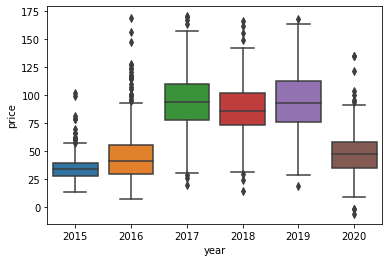

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Feature Engineering: year and month
df['year'] = [ts.year for ts in df.date]

# plot
sns.boxplot(x='year', y='price', data=df[df.price <= 170.63])
plt.show()

The monthly price of energy over the years also changes over time. **It is observed that price is higher in June [month number 6] and July [month number 7] than the rest except at 2015 and 2018**, the median [horizontal line into the boxes] for these months are the highest.

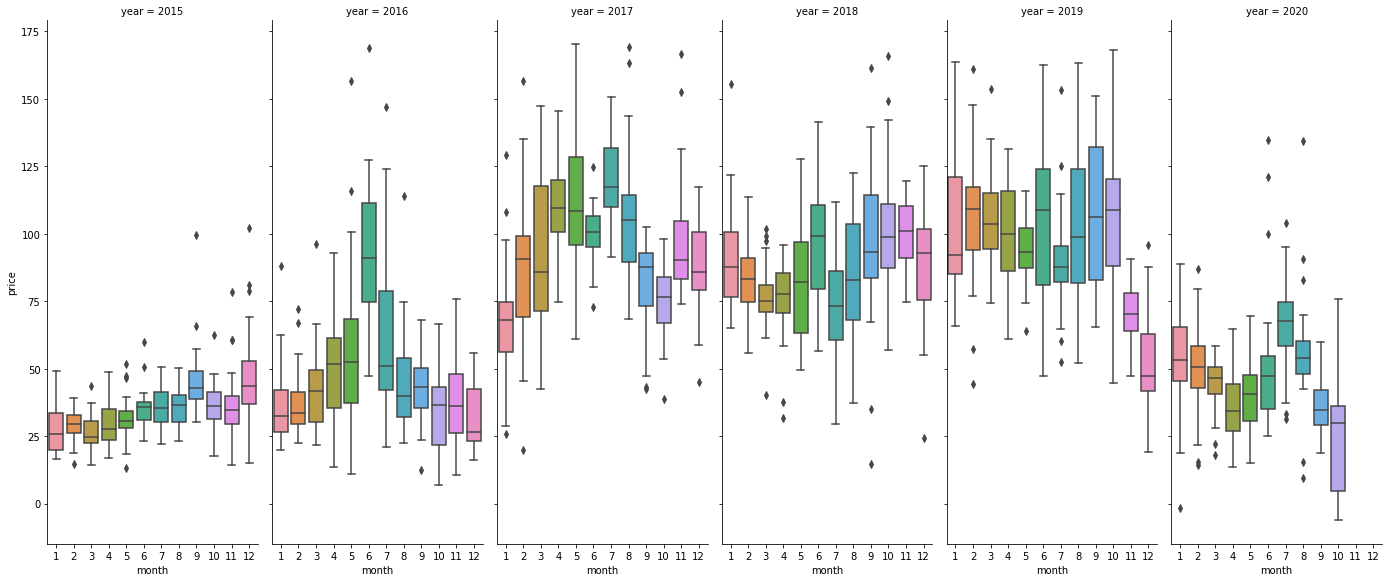

In [4]:
# Feature Engineering: month
df['month'] = [ts.month for ts in df.date]

# plot
sns.catplot(x='month', y='price', col='year', kind='box', data=df[df.price <= 170.63], height=8, aspect=.4)
plt.show()

**The price of energy varies throughout the days of the week**, Saturdays [value equal to 5] and Sundays [value equal to 6] are lower values than the rest of the days of the week, weekend medians are lowest.

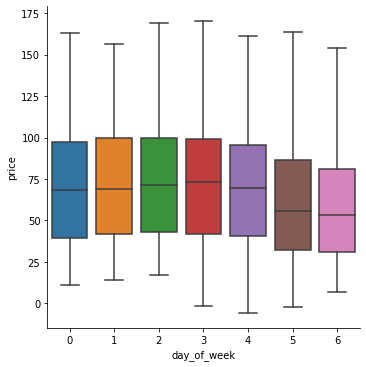

In [5]:
# Feature Engineering: day of week
df['day_of_week'] = [ts.day_of_week for ts in df.date]

# plot
sns.catplot(x='day_of_week', y='price', kind='box', data=df[df.price < 170.63])
plt.show()

## Forcasting Model

It is created a forcasting model using the variables propose before:

year, month and day_of_week

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                2106 non-null   datetime64[ns]
 1   demand              2106 non-null   float64       
 2   price               2106 non-null   float64       
 3   demand_pos_price    2106 non-null   float64       
 4   price_positive      2106 non-null   float64       
 5   demand_neg_price    2106 non-null   float64       
 6   price_negative      2106 non-null   float64       
 7   frac_neg_price      2106 non-null   float64       
 8   min_temperature     2106 non-null   float64       
 9   max_temperature     2106 non-null   float64       
 10  solar_exposure      2105 non-null   float64       
 11  rainfall            2103 non-null   float64       
 12  school_day          2106 non-null   object        
 13  holiday             2106 non-null   object      

In [ ]:
from sklearn.linear_model import LinearRegression

X = df[['year', 'month', 'day_of_week']]
y = df.price

model1 = LinearRegression()
model1.fit(X, y)


LinearRegression()

In [ ]:
model1.coef_

array([10.55881704, -2.16317373, -1.98258808])

In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
X = [i + 1 for i in range(11)]
X = np.array(X).reshape(-1,1)
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X)

OneHotEncoder(handle_unknown='ignore')

In [ ]:
df.day_of_week.unique()

array([3, 4, 5, 6, 0, 1, 2])

In [ ]:
l = [[[i + 1, j] for j in range(7)] for i in range(12)]
X_month_day = np.array(l).reshape(-2,2).tolist()
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(X_month_day)

OneHotEncoder(handle_unknown='ignore')

In [ ]:
enc.categories_

[array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([0, 1, 2, 3, 4, 5, 6])]

In [ ]:
list_prices = df.price[1800:1802].values.tolist()
list_months_daysweek = enc.transform(df[['month','day_of_week']].values[1800:1802]).toarray().tolist()

In [ ]:
list_prices

[41.38035927320447, 47.12307019341698]

In [ ]:
# Add prices
X_potencial = [[list_prices[i]] + lmdw for i, lmdw in zip(range(2), list_months_daysweek)]

In [ ]:
np.array(X_potencial)

array([[41.38035927,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ],
       [47.12307019,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ]])

In [ ]:
enc.transform(df['month'].values[1800:1802].reshape(-1,1)).toarray()

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
df[['month','day_of_week']].values[1800:1802]

array([[12,  4],
       [12,  5]])

### Relation between Energy's Price and numeric variables

Following Economy theory, the prices of a thing or service are built by its demand and its supply. The energy's price will increase if the demand is greater than the supply and the energy's price will decrease if the demand is less than the supply. In addition, there is a positive relationship between price and demand, so the higher the demand, the higher the price. And there is a negative relationship between price and supply, so the higher the supply, the lower the price.

$EnergyPrice = F(Demand, Supply)$

Saddenly the dataset does not have variables that play the rol of the Supply. So it is assumed that Supply will be the same accross time. It is a strong assumption but it is necessary in abstractions settings. In futures iterations build a Supply Model getting different variables is a recommendation.

Let is checked the Relationship between Energy's Price and its Demand. After take the base 10 logarithm positive relationship between price and demand is confirmed. It is also observed that the relationship is not linear, for higher demand's value the price's value increase faster than lower demand's value.

# Activities

To Do

- Incorporate into the function the possibility of fitting models with variable demand transformed by Log10
- Apply Cross Validation

Done
- Create Documentation of the last function.
- What is and how to detect overfitting? Overfitting is a possible cause of poor generalization performance of a predictive model [Model Performance on training data is significantly better than the performance on testing data ]. Overfitting can be analyzed for machine learning models by varying key model hyperparameters using learning curves [plot model behavior with train and test dataset]. Although overfitting is a useful tool for analysis, it must not be confused with model selection. Always select a model with best behavior in unseen data. [Good Blog: https://machinelearningmastery.com/overfitting-machine-learning-models/]. Possible solutions: reduce complexity of the model.
- What is and how to detect underfitting? Undefitting is when your model have bad performance in train and test datasets or its performance are worse in train dataset than test dataset. The way to detect it is ploting learning curves. [Good Blog: https://towardsdatascience.com/is-your-model-overfitting-or-maybe-underfitting-an-example-using-a-neural-network-in-python-4faf155398d2]. Possible solution: increase complexity of the model.
- Is better a low RMSE or a Hihg RMSE? The best model is which with lowest RMSE value.
- Create a function that allow create model standarizing variables and using different grades of demand variable [split data, preprocessing[standarize], fit model, get predictions, evaluate and store main information]
- Get all combination from two or more lists python
- Get predictions using model_train over X_test data and finally evaluate it.
- Evaluate the model. To do that it is necessary split data in train and test data.
- Create new variables: apply standardize technique over demand and price variable.
- Create scatterplot using demandStandardized and PriceStandardized.
- Fit polynomial Regression using demand and prices standardized. For do that it is neccessary create others variables that represent higher degrees of variable demand. 
- Plot predictions genereted by the model.

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import itertools

def create_models_stand_grades_demand(df_X, df_y, to_the_degree):
    """
    Create a Linear Regression Models to modelate energy's price with demand variable.
    Following:
    1. Split data
    2. Standarize variables
    3. Generate different polynomial grades of demand variable 
    4. Fit model
    5. Get predictions
    6. Evaluate using Root Mean Squared Errors [RMSE]
    7. Store main information
    
    Args:
        df_X: Demand variable like pandas.DataFrame object
        df_y: Energy's price like pandas.DataFrame object
        to_the_degree: int that control the degree parameter in PolynomialFeatures() class.
            And it also control the number of models to be fitted. So if to_the_degree = 3
            then three Linear Regression Models [LRM] will be fitted:
                - LRM with degree 1
                - LRM with degree 2
                - LRM with degree 3
        

    Returns:
        Pandas.DataFrame: DataFrame with RMSE train and test values for each model fitted.
    """
    # Generate list of grades
    degrees = [i + 1 for i in range(to_the_degree)]
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(df_X,
                                                        df_y, test_size=0.4, random_state=2256)

    # Standardize demand and price
    standardizer = StandardScaler()
    X_train['demandStandardized'] = standardizer.fit_transform(X_train.demand.values.reshape(-1,1))
    y_train['priceStandardized'] = standardizer.fit_transform(y_train.price.values.reshape(-1,1))
    X_test['demandStandardized'] = standardizer.fit_transform(X_test.demand.values.reshape(-1,1))
    y_test['priceStandardized'] = standardizer.fit_transform(y_test.price.values.reshape(-1,1))
    
    # Apply logarithm to the demand variable
    X_train['demandLog10'] = 
    
    
    # Get main information
    df_summary = pd.DataFrame()
    for i, degree in enumerate(degrees):
        
        # Name model
        name_model = 'LinRegStandGrade' + str(degree)
        # print('Fitting model {} ...'.format(name_model))
        
        # Crete new variables with different grades of demandStandardized variable
        polyfeatures = PolynomialFeatures(degree=degree)
        X_demand_train = polyfeatures.fit_transform(np.array(X_train.demandStandardized).reshape(-1, 1))
        X_demand_test = polyfeatures.fit_transform(np.array(X_test.demandStandardized).reshape(-1, 1))

        # Fit model
        model_train = LinearRegression(fit_intercept=False)
        model_train.fit(X_demand_train, y_train.priceStandardized)

        # Predictions
        # Train
        predictions_train = model_train.predict(X_demand_train)
        # Test
        predictions_test = model_train.predict(X_demand_test)

        # Evaluate model
        rmse_train = MSE(y_train.priceStandardized, predictions_train, squared=False)
        rmse_test = MSE(y_test.priceStandardized, predictions_test, squared=False)
        # print('Train RMSE: {} and Test RMSE: {}'.format(rmse_train, rmse_test))

        # Store main data
        df_summary = pd.concat([df_summary,
                                pd.DataFrame({'name':name_model,
                                   'Train_RMSE': rmse_train,
                                   'Test_RMSE': rmse_test}, index=[i])])
    # Return
    return df_summary
        

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE
import numpy as np
import itertools


# Inputs
df_X = pd.DataFrame(df['demand'])
df_y = pd.DataFrame(df['price'])
degrees = [i + 1 for i in range(10)]

# Split data
X_train, X_test, y_train, y_test = train_test_split(df_X,
                                                    df_y, test_size=0.4, random_state=2256)

# Standardize demand and price
standardizer = StandardScaler()
X_train['demandStandardized'] = standardizer.fit_transform(X_train.demand.values.reshape(-1,1))
y_train['priceStandardized'] = standardizer.fit_transform(y_train.price.values.reshape(-1,1))
X_test['demandStandardized'] = standardizer.fit_transform(X_test.demand.values.reshape(-1,1))
y_test['priceStandardized'] = standardizer.fit_transform(y_test.price.values.reshape(-1,1))

# Apply logarithm to the demand variable
X_train['demandLog10'] = np.log10(df.demand)
y_train['priceLog10'] = np.log10(df.price)
X_test['demandLog10'] = np.log10(df.demand)
y_test['priceLog10'] = np.log10(df.price)

demands = ['demand', 'demandStandardized']
prices = ['price', 'priceStandardized']
combinations = list(product(demands, prices))

# Get main information
df_summary = pd.DataFrame()
for demand, price in zip(demands, prices):
    for degree in degrees:

        # Name model
        name_model = 'LinRegGrade' + str(degree) + demand + price
        # print('Fitting model {} ...'.format(name_model))

        # Crete new variables with different grades of demandStandardized variable
        polyfeatures = PolynomialFeatures(degree=degree)
        X_demand_train = polyfeatures.fit_transform(np.array(X_train[demand]).reshape(-1, 1))
        X_demand_test = polyfeatures.fit_transform(np.array(X_test[demand]).reshape(-1, 1))

        # Fit model
        model_train = LinearRegression(fit_intercept=False)
        model_train.fit(X_demand_train, y_train[price])

        # Predictions
        # Train
        predictions_train = model_train.predict(X_demand_train)
        # Test
        predictions_test = model_train.predict(X_demand_test)

        # Evaluate model
        rmse_train = MSE(y_train[price], predictions_train, squared=False)
        rmse_test = MSE(y_test[price], predictions_test, squared=False)
        # print('Train RMSE: {} and Test RMSE: {}'.format(rmse_train, rmse_test))

        # Store main data
        df_summary = pd.concat([df_summary,
                                pd.DataFrame({'name':name_model,
                                   'Train_RMSE': rmse_train,
                                   'Test_RMSE': rmse_test}, index=[0])])

df_summary.sort_values(by='Test_RMSE', ascending=True)

,name,Train_RMSE,Test_RMSE
0,LinRegGrade5demandStandardizedpriceStandardized,0.918739,0.598800
0,LinRegGrade4demandStandardizedpriceStandardized,0.918855,0.616611
0,LinRegGrade6demandStandardizedpriceStandardized,0.917448,0.706684
0,LinRegGrade3demandStandardizedpriceStandardized,0.927845,0.726332
0,LinRegGrade2demandStandardizedpriceStandardized,0.960812,0.886424
0,LinRegGrade1demandStandardizedpriceStandardized,0.983431,0.962891
0,LinRegGrade9demandStandardizedpriceStandardized,0.912399,1.007219
0,LinRegGrade7demandStandardizedpriceStandardized,0.914797,1.040722
0,LinRegGrade8demandStandardizedpriceStandardized,0.913047,1.576630
0,LinRegGrade10demandStandardizedpriceStandardized,0.906333,2.608566


In [13]:
from itertools import product
   
demands = ['demand', 'demandStandardized', 'demandLog10']
prices = ['price', 'priceStandardized', 'priceLog10']
list(product(demands, prices))

[('demand', 'price'),
 ('demand', 'priceStandardized'),
 ('demand', 'priceLog10'),
 ('demandStandardized', 'price'),
 ('demandStandardized', 'priceStandardized'),
 ('demandStandardized', 'priceLog10'),
 ('demandLog10', 'price'),
 ('demandLog10', 'priceStandardized'),
 ('demandLog10', 'priceLog10')]

In [42]:
# Using function

# Inputs
df_X = pd.DataFrame(df['demand'])
df_y = pd.DataFrame(df['price'])

# Get Models
models = create_models_stand_grades_demand(df_X, df_y, to_the_degree=10)
models

,name,Train_RMSE,Test_RMSE
0,LinRegStandGrade1,0.983431,0.962891
1,LinRegStandGrade2,0.960812,0.886424
2,LinRegStandGrade3,0.927845,0.726332
3,LinRegStandGrade4,0.918855,0.616611
4,LinRegStandGrade5,0.918739,0.598800
5,LinRegStandGrade6,0.917448,0.706684
6,LinRegStandGrade7,0.914797,1.040722
7,LinRegStandGrade8,0.913047,1.576630
8,LinRegStandGrade9,0.912399,1.007219
9,LinRegStandGrade10,0.906333,2.608566


In [34]:
models.index.name = 'Grades'
models

,name,Train_RMSE,Test_RMSE
Grades,,,
1,LinRegStandGrade1,0.983431,0.962891
2,LinRegStandGrade2,0.960812,0.886424
3,LinRegStandGrade3,0.927845,0.726332
4,LinRegStandGrade4,0.918855,0.616611
5,LinRegStandGrade5,0.918739,0.598800
6,LinRegStandGrade6,0.917448,0.706684
7,LinRegStandGrade7,0.914797,1.040722
8,LinRegStandGrade8,0.913047,1.576630
9,LinRegStandGrade9,0.912399,1.007219


<AxesSubplot:xlabel='Grades'>

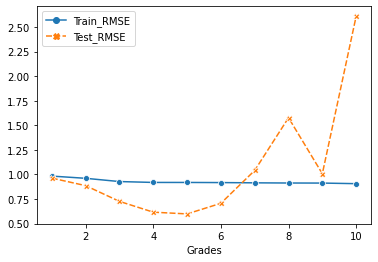

In [36]:
import seaborn as sns
sns.lineplot(data=models.iloc[:,1:3], markers=True)

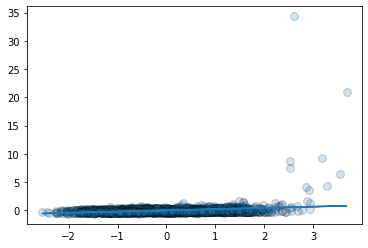

In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

# Standardize demand and price
standardizer = StandardScaler()
df['demandStandardized'] = standardizer.fit_transform(df.demand.values.reshape(-1,1))
df['priceStandardized'] = standardizer.fit_transform(df.price.values.reshape(-1,1))


# Scatter Plot
# sns.scatterplot(data=df, x="demandStandardized", y="priceStandardized", alpha=0.3)
# plt.show()

# Crete new variables with different grades of demandLog10 variable
polyfeatures = PolynomialFeatures(degree=1, include_bias=False)
X_demand = polyfeatures.fit_transform(np.array(df.demandStandardized).reshape(-1, 1))
X_demand

# Fit model
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
model.fit(X_demand, df.priceStandardized)
predictions = model.predict(X_demand)
predictions


# Plot predictions
# Initialize layout
fig, ax = plt.subplots()

# Add scatterplot
ax.scatter(df.demandStandardized, df.priceStandardized, s=60, alpha=0.2, edgecolors="k")

# Plot regression line
ax.plot(df.demandStandardized, predictions)

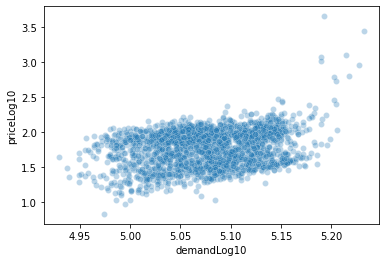

In [ ]:
# Plot scatter plot for both variables
import numpy as np
df['demandLog10'] = df.demand.apply(lambda x: np.log10(x))
df['priceLog10'] = df.price.apply(lambda x: np.log10(x))
sns.scatterplot(data=df, x="demandLog10", y="priceLog10", alpha=0.3)
plt.show()

In [ ]:
# Crete new variables with different grades of demandLog10 variable
from sklearn.preprocessing import PolynomialFeatures
polyfeatures = PolynomialFeatures(degree=5, include_bias=False)
X_demand = polyfeatures.fit_transform(np.array(df.demandLog10).reshape(-1, 1))
X_demand

array([[   4.99841206,   24.98412308,  124.88094201,  624.20640611,
        3120.04082566],
       [   5.11262514,   26.13893583,  133.63858048,  683.24396634,
        3493.17027964],
       [   5.15320655,   26.55553773,  136.84617091,  705.19658401,
        3634.02365446],
       ...,
       [   4.97350453,   24.73574734,  123.02335153,  611.85719649,
        3043.07454033],
       [   5.05541667,   25.55723775,  129.20248589,  653.17240156,
        3302.05865021],
       [   5.08851725,   25.8930078 ,  131.75701684,  670.44785294,
        3411.58546469]])

In [ ]:
# Third fit polinomial model
from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=False)
#model = LinearRegression()
model.fit(X_demand, df.price)
predictions = model.predict(X_demand)
predictions

array([ 34.79055673,  54.99026343, 108.56588364, ...,  34.95746996,
        81.51030864,  70.53690625])

In [ ]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import numpy as np

# First Standardize features
scaler = StandardScaler()
X = np.array(df[df.price < 179.63][['price','demand']])
#X = df[['price','demand']]
scaler.fit(X)
data_centered = scaler.transform(X)
demand = [i[1] for i in data_centered]
price = [i[0] for i in data_centered]

# Second Create polinomial combination of demand
polyfea = PolynomialFeatures(degree=2, include_bias=False)
X_demand = polyfea.fit_transform(np.array(demand).reshape(-1, 1))

# Third fit polinomial model
model = LinearRegression(fit_intercept=False)
#model = LinearRegression()
model.fit(X_demand, price)
predictions = model.predict(X_demand)
#b, c, d, e, f = model.coef_
#y_hat = [i * np.array([b, c, d, e, f]) for i in X_demand]
#y_hat = [np.sum(i) for i in y_hat]

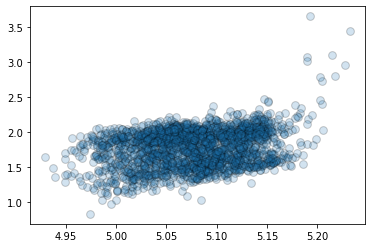

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import numpy as np

# Initialize layout
fig, ax = plt.subplots()

# Add scatterplot
ax.scatter(np.log10(df.demand), np.log10(df.price), s=60, alpha=0.2, edgecolors="k")
#ax.scatter(df.demand.values, y_hat, s=60, alpha=0.2, edgecolors="k")


# Plot regression line
#ax.plot(demand, predictions)

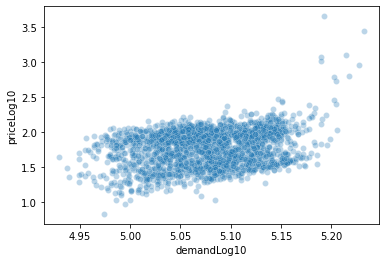

The Demand and Supply depend on many things. For example, Demand could depend of family income, Gross Domestic Product [GDP], Customer Expectations about the Energy Price, Fossil Fuel Prices, Weather Conditions, the variables in the data set, etc. Supply depend of Capital Invested in Production, Goverment Spend in Energy Market, Energy Market Regulations, etc. So each one could be a function itself.

$Demand = Q(Many Variables)$

$Supply = S(Many Variables)$

, however it will be assumed that each one will depend of different units of time i.e. year, month, day of week like the energy's price. Below it will be shown the Demand and Supply behavior across time.


$Demand = Q(different units of time)$

$Supply = S(different units of time)$


The energy's price have a positive relationship with the demand, demand_pos_price and price_positive variables. There are a negative relationship with the demand_neg_price, frac_neg_price, min_temperature, max_temperature, solar_exposure and rainfall.


- "date" - from January 1, 2015, to October 6, 2020.
- "demand" - daily electricity demand in MWh.
- "price" - recommended retail price in AUD/MWh.
- "demand_pos_price" - total daily demand at a positive price in MWh.
- "price_positive" - average positive price, weighted by the corresponding intraday demand in AUD/MWh.
- "demand_neg_price" - total daily demand at a negative price in MWh.
- "price_negative" - average negative price, weighted by the corresponding intraday demand in AUD/MWh.
- "frac_neg_price" - the fraction of the day when the demand traded at a negative price.
- "min_temperature" - minimum temperature during the day in Celsius.
- "max_temperature" - maximum temperature during the day in Celsius.
- "solar_exposure" - total daily sunlight energy in MJ/m^2.
- "rainfall" - daily rainfall in mm.
- "school_day" - "Y" if that day was a school day, "N" otherwise.
- "holiday" - "Y" if the day was a state or national holiday, "N" otherwise.

In [ ]:
# Demand

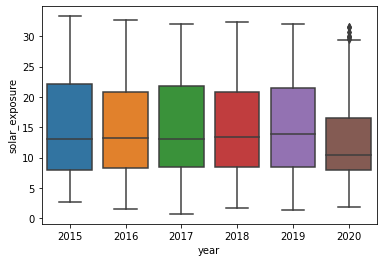

In [ ]:
# plot
sns.boxplot(x='year', y='solar_exposure', data=df)
plt.show()

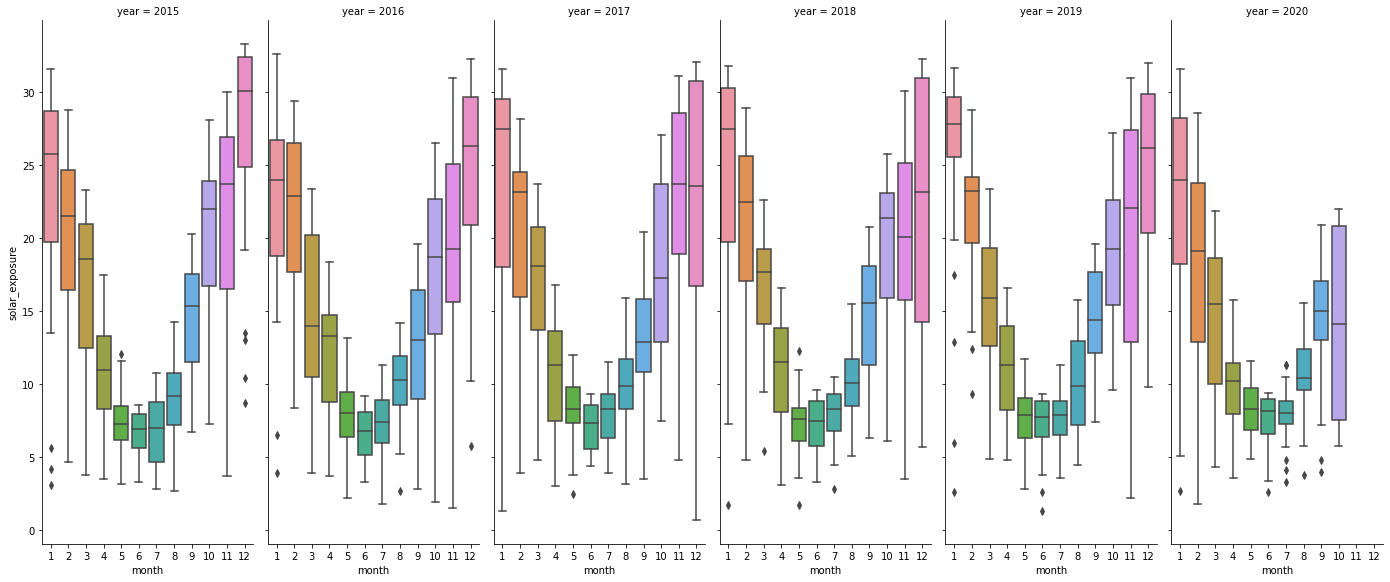

In [ ]:
# plot
sns.catplot(x='month', y='solar_exposure', col='year', kind='box', data=df, height=8, aspect=.4)
plt.show()

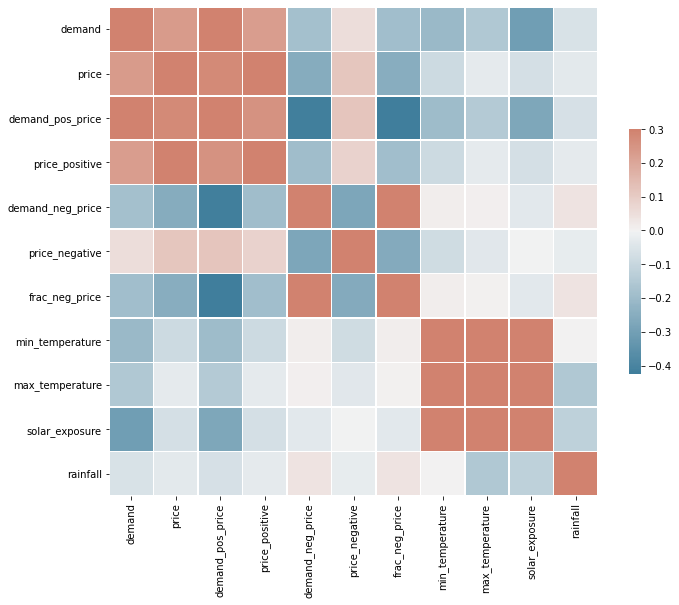

In [ ]:
import numpy as np
df_corr = df.drop(['year', 'month', 'day_of_week', 'outlier_price', 'date', 'school_day', 'holiday'], axis=1)
df_corr.head()

# sns.set_theme(style="white")
# Compute the correlation matrix
corr = df_corr[df_corr.price < 180].corr()

# Generate a mask for the upper triangle
#mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

## 🧑‍⚖️ Judging criteria

| CATEGORY | WEIGHTING | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **Recommendations** | 35%       | <ul><li>Clarity of recommendations - how clear and well presented the recommendation is.</li><li>Quality of recommendations - are appropriate analytical techniques used & are the conclusions valid?</li><li>Number of relevant insights found for the target audience.</li></ul>       |
| **Storytelling**  | 35%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in-depth enough but also concise.</li></ul> |
| **Visualizations** | 20% | <ul><li>Appropriateness of visualization used.</li><li>Clarity of insight from visualization.</li></ul> |
| **Votes** | 10% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

## ✅ Checklist before publishing into the competition
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the judging criteria, so the workbook is focused on your story.
- Make sure the workbook reads well and explains how you found your insights. 
- Try to include an **executive summary** of your recommendations at the beginning.
- Check that all the cells run without error.

## ⌛️ Time is ticking. Good luck!